# June 10,13-16, 2022: model interpretation(s) on simulated data with white noise

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob
from sklearn import metrics

from IPython.display import Image

# explanation tools
import captum
from captum.attr import Saliency, IntegratedGradients

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.pytorch.dataset_utils as dataset_utils
import helpers.pytorch.model_definitions as model_definitions
import helpers.pytorch.model_helpers as model_helpers
import helpers.pytorch.plot_utils as plot_utils
import helpers.pytorch.interpretation_helpers as interp_helpers

# cuda device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

True
Using cuda:1 device


### main (original) data

In [2]:
'''
dataframe
'''
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

# set random seed
torch.manual_seed(args.SEED)
np.random.seed(args.SEED)

# data
args.num_subjects = len(max_data_df)
args.num_train = round(0.4 * args.num_subjects)
args.num_valid = round(0.3 * args.num_subjects)
args.num_test = args.num_subjects - args.num_train - args.num_valid

# num_rois = 85
# args.roi_idxs = np.arange(num_rois)
args.roi_idxs = np.array([23, 24, 36, 37, 38, 39, 43])
'''
rois
0, 1, 3, 4,
20, 21, 22, (23, 24),
(36, 37, 38, 39),
(43), 
51, 52,
59,
(60, 61, 62, 63, 64),
83
'''

'''
generate dataset for the model
'''
subject_idx_list = np.arange(args.num_subjects)
random.Random(args.SEED).shuffle(subject_idx_list)

train_idx_list = subject_idx_list[:args.num_train]
valid_idx_list = subject_idx_list[args.num_train : args.num_train + args.num_valid]
test_idx_list = subject_idx_list[args.num_train + args.num_valid:]

(X_train, y_train) = dataset_utils.get_max_data_trials(args, max_data_df, train_idx_list)
(X_valid, y_valid) = dataset_utils.get_max_data_trials(args, max_data_df, valid_idx_list) 
(X_test, y_test) = dataset_utils.get_max_data_trials(args, max_data_df, test_idx_list)

100%|██████████| 32/32 [00:00<00:00, 5641.06it/s]


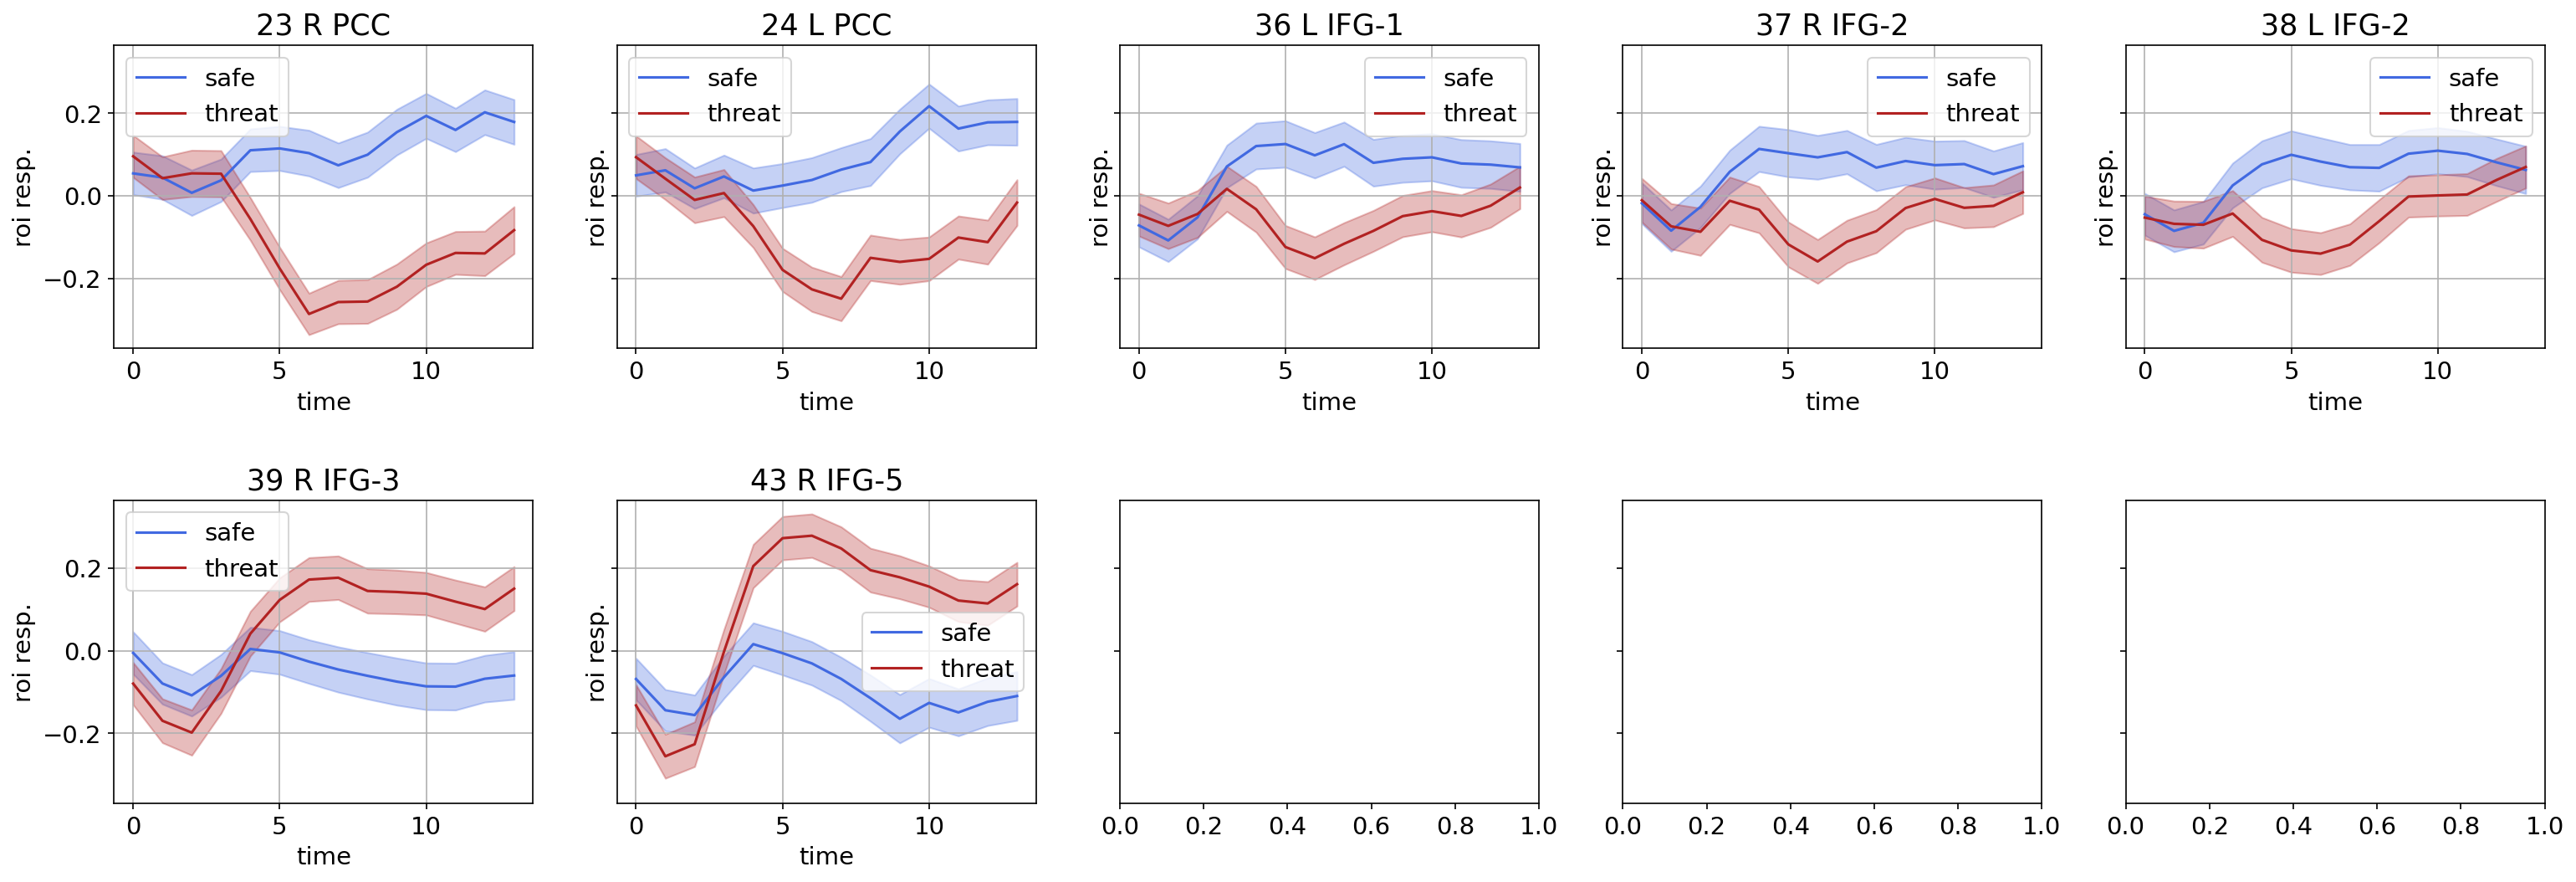

In [3]:
plot_utils.plot_roi_time_series(args, X_train, y_train)

### multiple repetitions of noise samples

In [4]:
def collect_fit_out(fit_outputs, fit_out):
    fit_outputs['best_models'] += [fit_out['best_model']]
    fit_outputs['best_epochs'] += [fit_out['best_epoch']]


    H = fit_outputs['histories']
    h = fit_out['history']

    if len(H) == 0:
        for k in h.keys():
            H[k] = np.array([])

    for k in h.keys():
        H[k] = np.vstack([h[k], H[k]]) if H[k].size else h[k]

    # fit_outputs['histories'] = H
        
def single_repetition(noise_level=1.0):
    '''
    data
    '''
    args.noise_level = noise_level
    X_train_, y_train_ = dataset_utils.sim_data_additive_white_noise(args, X_train, y_train)
    X_valid_, y_valid_ = dataset_utils.sim_data_additive_white_noise(args, X_valid, y_valid)
    X_test_, y_test_ = dataset_utils.sim_data_additive_white_noise(args, X_test, y_test)
    # plot_utils.plot_roi_time_series(args, X_train_, y_train_)

    '''
    model
    '''
    args.input_dim = X_train_.shape[-1]
    args.out_dim = len(args.LABELS)
    args.hidden_dim = 8
    args.num_epochs = 75
    args.batch_size = 64
    args.dropout = 0.5

    model = model_definitions.GRU_classifier(args)
    criterion = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters())

    model.to(device)
    criterion.to(device)

    data = (
        torch.FloatTensor(X_train_).to(device=device), torch.LongTensor(y_train_).to(device=device),
        torch.FloatTensor(X_valid_).to(device=device), torch.LongTensor(y_valid_).to(device=device),
        torch.FloatTensor(X_test_).to(device=device), torch.LongTensor(y_test_).to(device=device),
    )

    permuts = (
        torch.randperm(X_train_.shape[0]),
        torch.randperm(X_valid_.shape[0]),
        torch.randperm(X_test_.shape[0]),
    )

    fit_out = model_helpers.fit(model, args, data, permuts, criterion, optimizer)

    return (data, permuts, criterion, optimizer), fit_out
    
noise_level = 1.0
# fig_file = (
#     f"{results_dir}/max/sim_data/white_noise/"
#     f"training_curves_num_rois_{len(args.roi_idxs)}_noise_level{noise_level}.png"
# )

# if not os.path.exists(fig_file):
#     fit_outputs = {
#         'best_models': [],
#         'histories': {},
#         'best_epochs': []
#     }
#     args.num_repetitions = 50
#     for repetition in tqdm(np.arange(args.num_repetitions)):
#         _, fit_out = single_repetition(noise_level)
#         collect_fit_out(fit_outputs, fit_out)

#     model_helpers.plot_training_history(args, fit_outputs, save_fig=True, fig_file=fig_file)

# Image(fig_file)

### data and model

In [5]:
(data, permuts, criterion, optimizer), fit_out = single_repetition(noise_level)
model = fit_out['best_model']
print(f"validation loss and acc: {model_helpers.evaluate(model, args, data[2], data[3], criterion, permuts[1])}")

validation loss and acc: (0.557452317327261, 0.7010722607374191)


/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


In [6]:
model

GRU_classifier(
  (gru): GRU(7, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### model interpretation(s)

In [7]:
# validation data
X, y = data[2:4] 
X.shape, y.shape

(torch.Size([1016, 14, 7]), torch.Size([1016, 14]))

#### saliency

In [8]:
model.train()
interp_method = Saliency(model)
attributions = interp_helpers.get_attributions(args, X, y, model, interp_method)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [9]:
args.num_null = 500
hypotheses = {}
for label in args.LABELS:
    hypotheses[label] = interp_helpers.get_hypotheses(args, label, attributions, compute_null=False)

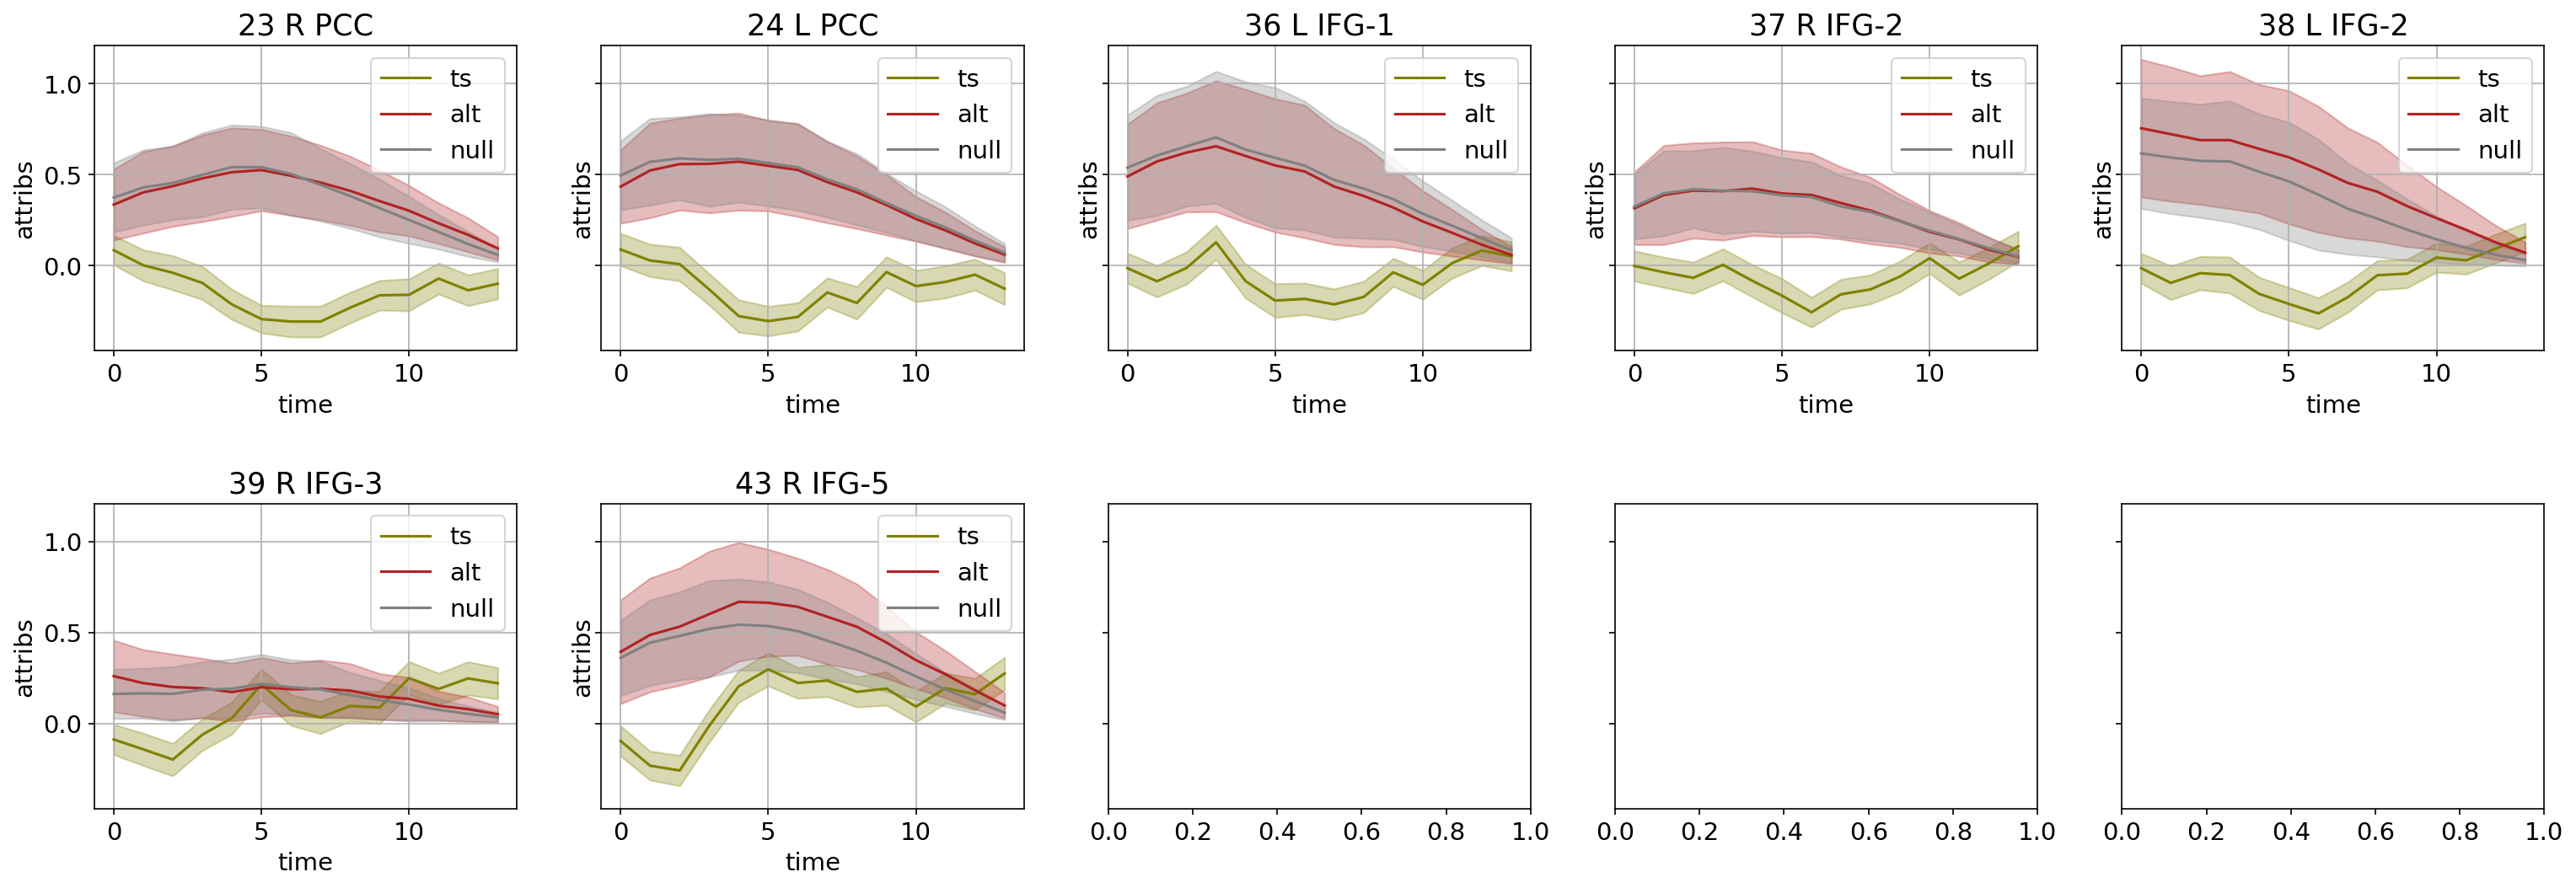

In [10]:
'''
data samples of the threat condition
'''
label = 1
plot_utils.plot_roi_attributions(args, X[y[:, 0]==label].cpu().numpy(), hypotheses[label])

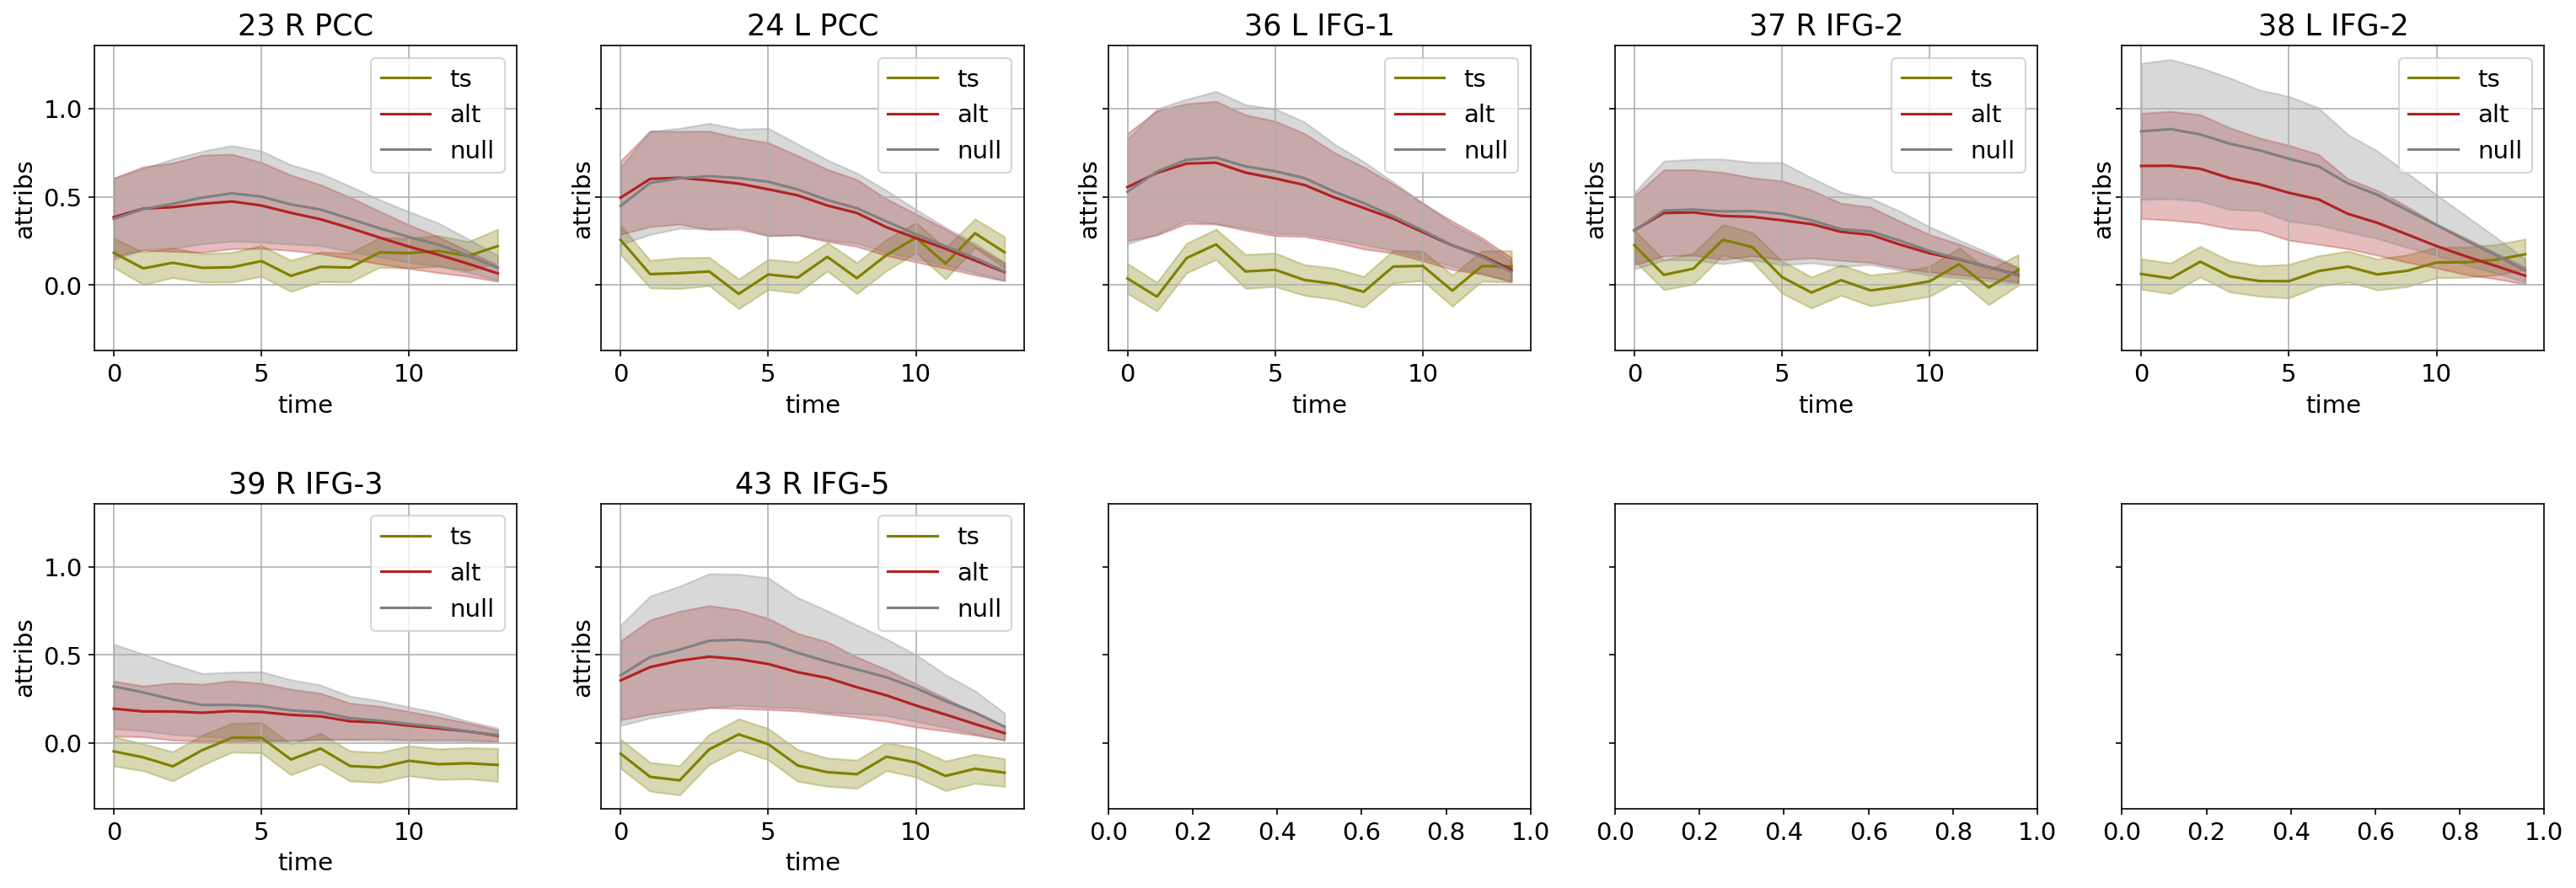

In [11]:
'''
data samples of the safe condition
'''
label = 0
plot_utils.plot_roi_attributions(args, X[y[:, 0]==label].cpu().numpy(), hypotheses[label])

#### integrated gradients

In [12]:
model.train()
# interp_method = Saliency(model)
interp_method = IntegratedGradients(model)
attributions = interp_helpers.get_attributions(args, X, y, model, interp_method)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


In [13]:
args.num_null = 500
hypotheses = {}
for label in args.LABELS:
    hypotheses[label] = interp_helpers.get_hypotheses(args, label, attributions, compute_null=False)

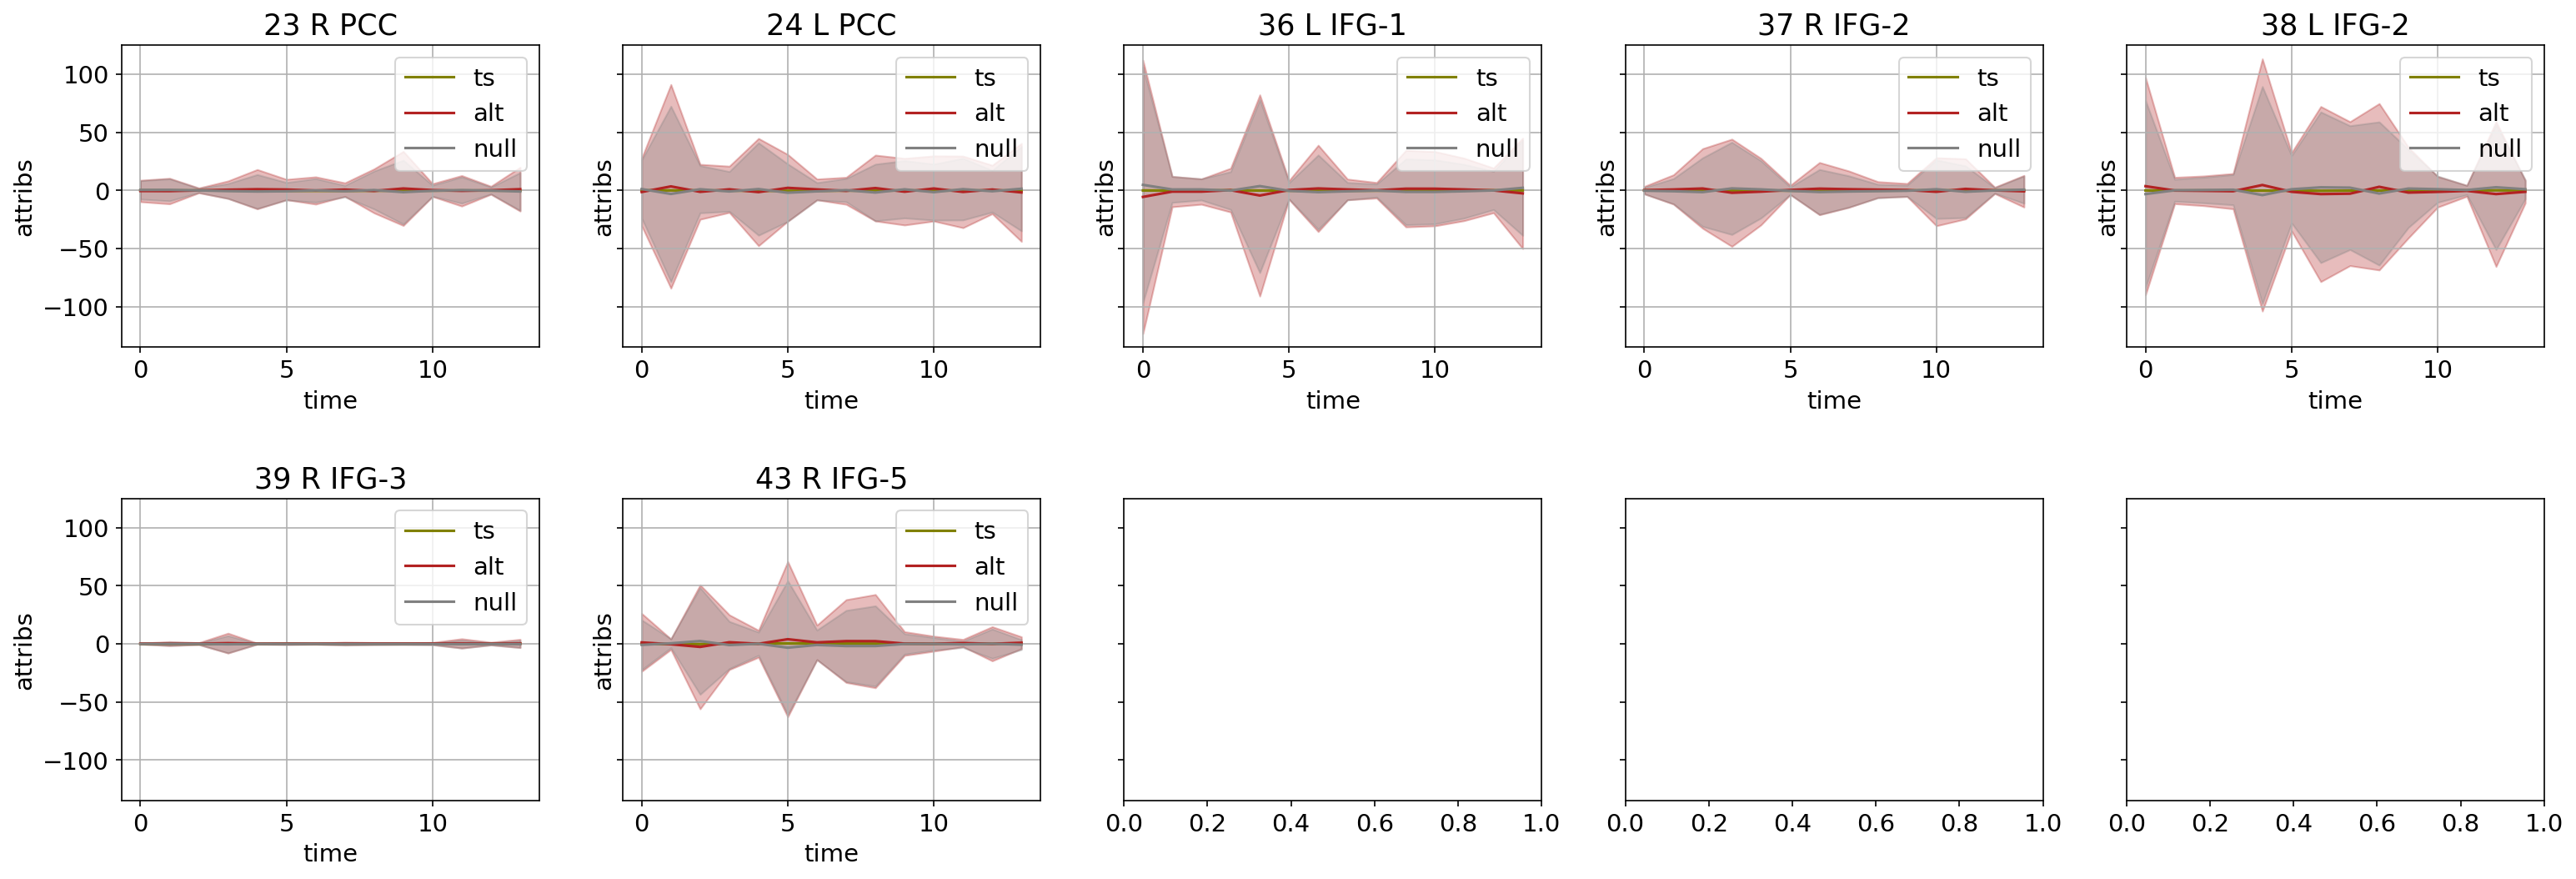

In [14]:
'''
data samples of the threat condition
'''
label = 1
plot_utils.plot_roi_attributions(args, X[y[:, 0]==label].cpu().numpy(), hypotheses[label])

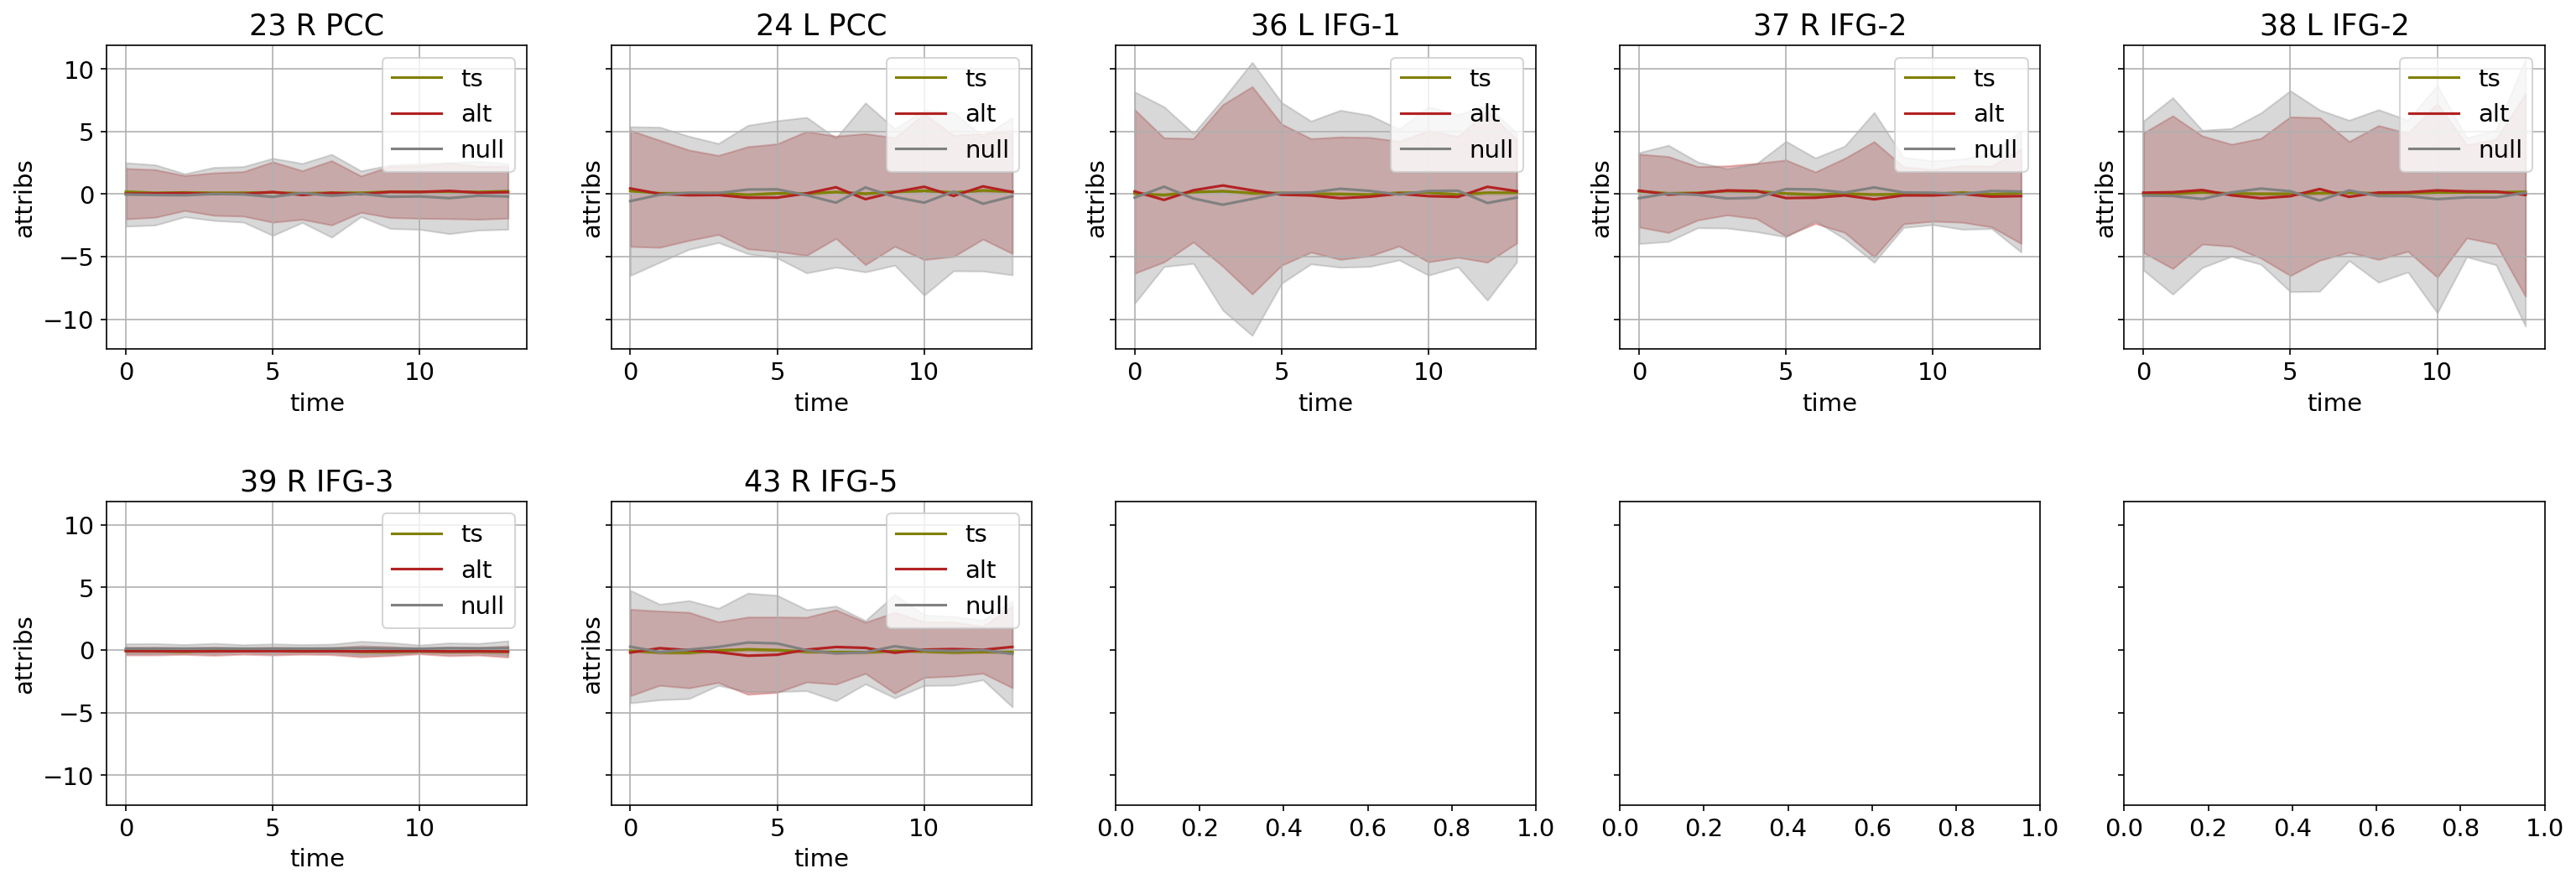

In [15]:
'''
data samples of the safe condition
'''
label = 0
plot_utils.plot_roi_attributions(args, X[y[:, 0]==label].cpu().numpy(), hypotheses[label])

### discussion

the saliency attributions of the input samples are of the same pattern across all rois; increase till the middle and then fall back to zero. 
in addition, they are not following the roi time series. 

and, attributions for both conditions add to zero: safe = -threat

#### to do

- [x] try with fewer handpicked rois. 
- [x] try with a simpler model, maybe a multilayer perceptron (mlp) or a basic recurrent neural network (rnn).